In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder

# Part 1: Data understanding and processing (EDA)

## 1.1 Get to know the data

In [298]:
path = './data.csv'
df = pd.read_csv(path)
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128061 entries, 0 to 128060
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Age                 128061 non-null  float64
 1   Gender              128061 non-null  object 
 2   Education           128061 non-null  int64  
 3   Introversion Score  128061 non-null  float64
 4   Sensing Score       128061 non-null  float64
 5   Thinking Score      128061 non-null  float64
 6   Judging Score       128061 non-null  float64
 7   Interest            128061 non-null  object 
 8   Personality         128061 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 8.8+ MB


(None, (128061, 9))

In [290]:
df.head(10)

,Age,Gender,Education,Introversion Score,Sensing Score,Thinking Score,Judging Score,Interest,Personality
0,19.0,Male,0,9.47080,7.141434,6.03696,4.360278,Unknown,ENFP
1,27.0,Female,0,5.85392,6.160195,0.80552,4.221421,Sports,ESFP
2,21.0,Female,0,7.08615,3.388433,2.66188,5.127320,Unknown,ENFP
3,28.0,Male,0,2.01892,4.823624,7.30625,5.986550,Others,INTP
4,36.0,Female,1,9.91703,4.755080,5.31469,4.677213,Technology,ENFP
5,25.0,Male,0,7.66292,5.758030,1.97014,4.563907,Others,ENFP
6,26.0,Female,1,2.73185,5.898910,3.64832,5.800525,Unknown,INFP
7,27.0,Female,0,5.24958,5.963290,1.16176,5.873350,Sports,ENFJ
8,29.0,Male,0,8.86018,3.681570,7.78505,1.640560,Others,ENTP
9,24.0,Female,0,1.62636,5.160906,7.25476,3.825849,Technology,INTP


This synthetic dataset is designed to explore and predict Myers-Briggs Type Indicator (MBTI) personality types based on a combination of demographic factors, interest areas, and personality scores. It includes 100K+ samples, each representing an individual with various features that contribute to determining their MBTI type. Features included in this dataset are:

**Age**: A continuous variable representing the age of the individual.

**Gender**: A categorical variable indicating the gender of the individual. Possible values are 'Male' and 'Female'.

**Education**: A binary variable, A value of 1 indicates the individual has at least a graduate-level education (or higher), and 0 indicates an undergraduate, high school level or Uneducated.

**Interest**: A categorical variable representing the individual's primary area of interest.

**Introversion Score**: A continuous variable ranging from 0 to 10, representing the individual's tendency toward introversion versus extraversion. Higher scores indicate a greater tendency toward extraversion.

**Sensing Score**: A continuous variable ranging from 0 to 10, representing the individual's preference for sensing versus intuition. Higher scores indicate a preference for sensing.

**Thinking Score**: A continuous variable ranging from 0 to 10, indicating the individual's preference for thinking versus feeling. Higher scores indicate a preference for thinking.

**Judging Score**: A continuous variable ranging from 0 to 10, representing the individual's preference for judging versus perceiving. Higher scores indicate a preference for judging.

**Personality**: Target that contains People Personality Type

The main goal for this project is to use different machine learning models to make prediction related to a person personality based on MBTI score. Since, the target variable contains multiple types of characteristics, its make the problem becomes a multiclass-classification.

## 1.2 Data cleaning and processing

### inconsistent column names

In [299]:
df.columns = df.columns.str.lower().str.replace(" ", "_")
print(list(df.columns))

['age', 'gender', 'education', 'introversion_score', 'sensing_score', 'thinking_score', 'judging_score', 'interest', 'personality']


### missing values

In [264]:
df.isnull().sum()

age                   0
gender                0
education             0
introversion_score    0
sensing_score         0
thinking_score        0
judging_score         0
interest              0
personality           0
dtype: int64

$\to$ No null values were found. "Unknown" values in 'interest' feature are keept as they are one of a way to handle missing values.

### duplicated values

In [265]:
dups_propotion = df.duplicated().sum()/df.shape[0]
dups_propotion

0.0

$\to$ Contains no duplicated values

### get categorical and numerical features

In [266]:
cat_f = list(df.select_dtypes(include='object'))
cat_f.append('education')
num_f = list(df.drop(columns=cat_f).columns)

cat_f, num_f

(['gender', 'interest', 'personality', 'education'],
 ['age',
  'introversion_score',
  'sensing_score',
  'thinking_score',
  'judging_score'])

In [267]:
# remove target variable
cat_f.remove('personality')

- Target variable: 'personality'
- Categorical features: 'gender', 'interest', 'education'
- Numerical features: 'age', 'introversion_score', 'sensing_score', 'thinking_score', 'judging_score'

### target label encoding

In [300]:
le = LabelEncoder()
df.personality = le.fit_transform(df.personality)
df.personality.value_counts()

personality
1     34404
3     24718
9     24711
11    17132
5      4832
0      3883
13     3456
7      3334
8      2919
2      2783
15     2390
10     1920
4       554
6       392
12      371
14      262
Name: count, dtype: int64

In [301]:
# create a dictionary to store mapped values for further investigation
personality_label1 = dict(map(lambda i, j: (i, j), 
                             range(len(le.classes_)), le.classes_))

personality_label

{0: 'ENFJ',
 1: 'ENFP',
 2: 'ENTJ',
 3: 'ENTP',
 4: 'ESFJ',
 5: 'ESFP',
 6: 'ESTJ',
 7: 'ESTP',
 8: 'INFJ',
 9: 'INFP',
 10: 'INTJ',
 11: 'INTP',
 12: 'ISFJ',
 13: 'ISFP',
 14: 'ISTJ',
 15: 'ISTP'}

### feature importance and engineering

In [166]:
for col in cat_t:
    print(df[col].value_counts(), "\n")
    print(f"Mutual info between retention and {col}: {mutual_info_score(df.personality, df[col])}", "\n")

gender
Male      70432
Female    57629
Name: count, dtype: int64 

Mutual info between retention and gender: 0.009695886596935873 

interest
Unknown       48835
Arts          25489
Others        21733
Technology    19103
Sports        12901
Name: count, dtype: int64 

Mutual info between retention and interest: 0.011921222195182116 

education
0    75408
1    52653
Name: count, dtype: int64 

Mutual info between retention and education: 0.057346709323561486 



$\to$ The mutual information of each categorical feature tell us that gender is likely to not produce any useful information in predicting personality. Hence, we will exclude it from the models.

In [167]:
df[num_t].corrwith(df.personality)

age                   0.057918
introversion_score   -0.757621
sensing_score         0.157343
thinking_score        0.191506
judging_score        -0.030594
dtype: float64

$\to$ Based on the correlation between different numerical features, we can see that **introversion_score**, **sensing_score,** and **thinking_score** are considered to have impact on inferencing a person trait. Especially, introversion_score are observed to be the most effected one.

As a result, the following features will be used for model training:

In [314]:
cat_f = [x for x in cat_f if x != 'gender']
num_f = [x for x in num_f if x not in ['age', 'judging_score']]

cat_f, num_f

(['interest', 'education'],
 ['introversion_score', 'sensing_score', 'thinking_score'])

### outliers

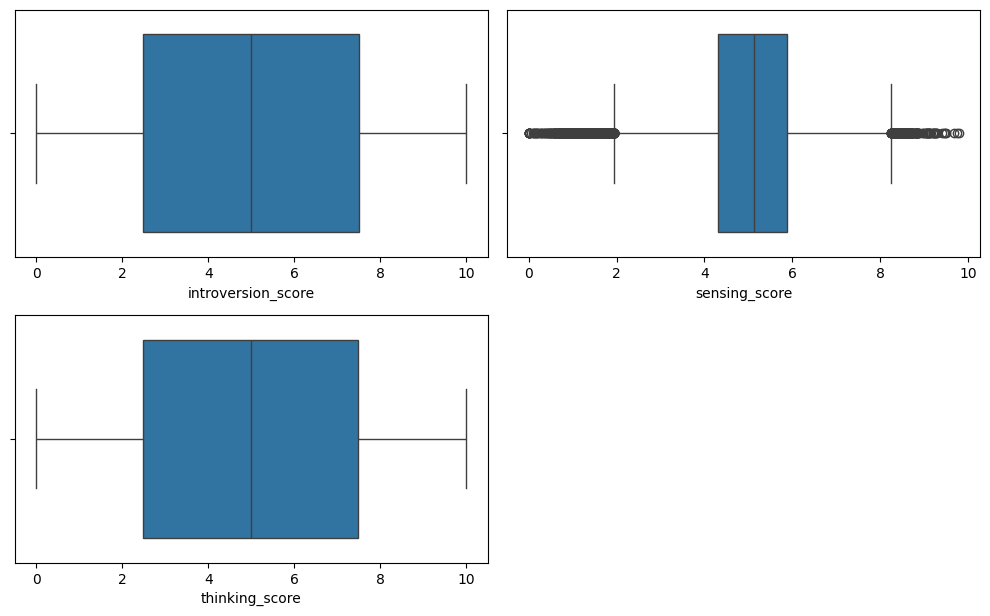

In [315]:
plt.figure(figsize=(10, 15))
for i, col in enumerate(num_f):
    plt.subplot(5, 2, i + 1)
    sns.boxplot(df, x=col)
plt.tight_layout()
plt.show()

$\to$ From the boxplots, we can observe that **sensing_score** varible contains multiple outilers that need to be addressed. But before we can decide wheter or not to remove outliers, it is important to first investigate the reason behind the existence of these values. And since some models are more sensitive to outliers than other, it also depends on the type of models we choose. Therefore, we will try to deal with outliers only when needed

### validation framework
60% training, 20% validation, 20% testing

In [316]:
# update dataframe to use only selected features
features = cat_f + num_f

# also include target variable
features.append('personality')

In [317]:
df_full_train, df_test = train_test_split(df[features], test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(76836, 25612, 25613)

In [318]:
df_full_train.head()

,interest,education,introversion_score,sensing_score,thinking_score,personality
37137,Unknown,0,0.77647,3.017397,3.57761,9
120517,Arts,0,9.73595,5.723747,0.94097,1
84967,Arts,0,4.28752,5.448390,5.80655,11
86045,Unknown,1,5.53467,5.625216,7.17642,3
109195,Arts,0,4.56679,5.503496,8.73073,3


In [319]:
# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# obtain target values
y_train = df_train.personality.values
y_val = df_val.personality.values
y_test = df_test.personality.values

In [320]:
# remove target to prevent using it
for i in [df_train, df_val, df_test]:
    del i["personality"]

### one-hot encoding for features

In [321]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[df_train.columns].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[df_val.columns].to_dict(orient='records')
X_val = dv.transform(val_dict)

test_dict = df_test[df_test.columns].to_dict(orient='records')
X_test = dv.transform(test_dict)

# Part 2: Model training
List of models used in this project:
- Logistic Regression (with Gradient Descent or Regularize - optional)
- Decision Tree
- Random Forest
- Gradient Boosting Machines (XGBoot, ...)
- Naive Bayes (optional)
- KNN

This section is divided into 5 parts:
- Models training
- Models evaluation part I
- Hyperparameter tunning
- Models evaluation part II
- Models selection

# Part 3: Deployment
This include:
- Save models to binary files
- Export notebook to python script